In [1]:
from scipy import stats
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arch
from dataloader import load_data

## Load Data

In [2]:
# load data
data = load_data(regular=False)
data.tail(3)

[*********************100%***********************]  2 of 2 completed


,SP500,VIX,log_returns,returns,real_3w_vol,India_VIX,US,global,cases_growth_US,cases_growth_global,cases_growth_India,covid_state_US
2021-01-06,3748.139893,25.070000,0.005694,0.005710,0.006667,20.995,21354750,87241950,0.010402,0.007924,0.001808,0
2021-01-07,3803.790039,22.370001,0.014738,0.014847,0.006910,20.615,21635491,88104210,0.010599,0.008027,0.001822,0
2021-01-08,3824.679932,21.559999,0.005477,0.005492,0.006969,20.640,21928012,88925739,0.010805,0.008172,0.001823,0


We plot the returns of SP500 index during COVID-19.

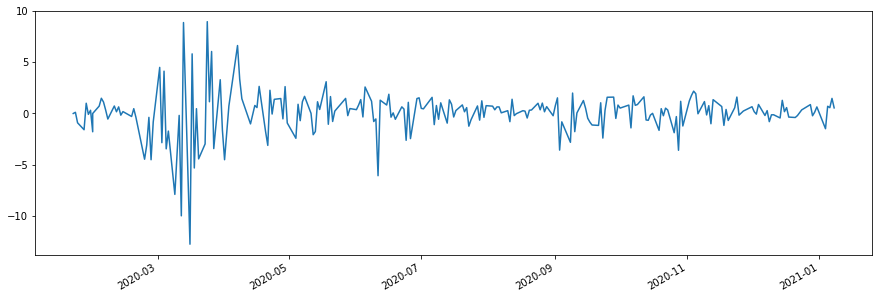

In [3]:
data['returns'] =  np.log(data.SP500 / data.SP500.shift(1)).fillna(0) * 100
data.returns.plot(figsize=(15,5))

## Frequentist Model I : Forecasting SP500 returns by ARCH model

The autoregressive conditional heteroscedasticity (ARCH) model is a statistical model for time series data that describes the variance of the current error term or innovation as a function of the actual sizes of the previous time periods' error terms; often the variance is related to the squares of the previous innovations. The ARCH model is appropriate when the error variance in a time series follows an autoregressive (AR) model; if an autoregressive moving average (ARMA) model is assumed for the error variance, the model is a generalized autoregressive conditional heteroskedasticity (GARCH) model.

ARCH models are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering, i.e. periods of swings interspersed with periods of relative calm.

To implement ARCH model, we need the following 5 steps:
- Check the stationarity of the series 
- If yes, build an AR model for the mean
- Test whether the residual has conditional heteroscedasticity effect
- If yes, build an ARCH model for the volatility
- Integrate two models together

Now we follow the steps and see how the model behave in fitting SP500 returns.

####  Step 1 - Check the stationarity of SP500 returns

First we use ADF test to check whether the returns of SP500 is stationary. That is:

- Null hypothesis $H_0$: the sequence is non-stationary 

- Alternative hypothesis $H_1$: the sequence is stationary

In [4]:
# ADF test
t = sm.tsa.stattools.adfuller(data.returns) 
print ("p-value: ",t[1])

p-value:  0.0013740073774273361


The p-value is less than the significance level, so the null hypothesis is rejected, Therefore. the sequence is stationary. 


#### Step 2 - Build an AR model
Autoregressive(AR) model is a statistical method of processing time series, using the same variable such as the previous periods of $x$, that is, $x_1$ to $x_{t-1}$ to predict the performance of $x_t$ in this period. And suppose they are a linear relationship. In this content, the AR model can be expressed as:

$$\begin{align*}
\qquad & r_t = c_1 + \sum_{i=1}^L{\phi_i r_{t-i}} + \epsilon_t \qquad &\epsilon_t \sim N(0,\sigma^2) \\
\end{align*}$$<br>

We use the partial autocorrelation function PACF to determine L.

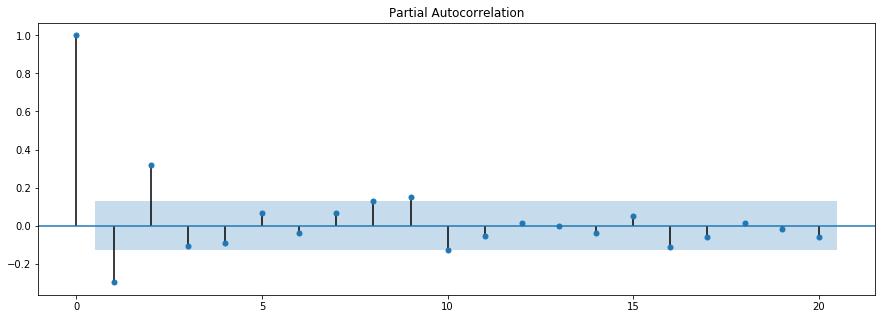

In [33]:
# plot partial autocorrelation for AR model
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fig = sm.graphics.tsa.plot_pacf(data.returns,lags = 20,ax = ax1)

Based on the graph, we choose $L=2$ and build an AR(2) model.

In [66]:
# set L=2
L = (2,0)
# build AR model
ar_model = sm.tsa.ARMA(list(data.returns), L).fit()

#### Step 3 - Test the autocorrelation of the residual

Let $\epsilon_t$ be the residuals

$$\epsilon_t = r_t - \hat{r}_t$$

We use Ljung-Box test to test the correlation of the sequence $\{\epsilon_t^2\}$  to determine whether it has the ARCH effect: 

- Null hypothesis $H_0$: the sequence has no serial correlation

- Alternative hypothesis $H_1$: the sequence has serial correlation

If the answer is yes, we will need to use another model to adapt to this situation.

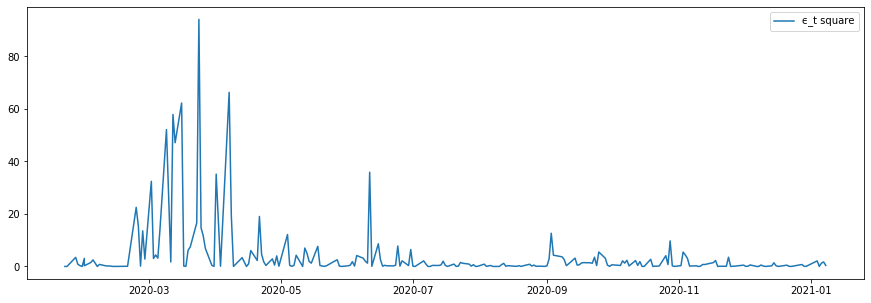

In [37]:
# Calculate the residuals
eps_t = data.returns -  ar_model.fittedvalues
eps_t2 = np.square(eps_t)

# Plot the residuals and the square of the residuals
plt.figure(figsize=(15,5))
plt.subplot(1,1,1)
plt.plot(eps_t2,label='ϵ_t square')
plt.legend()

In [58]:
# test first 10 correlation coefficients
test_n = 10
# calculate correlation coefficients and p-value
acf, q, p = sm.tsa.acf(eps_t2, nlags = test_n, qstat = True, fft = False) 
out = np.c_[range(test_n), acf[1:], q, p]
test_output = pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"]).set_index('lag')

print("Ljung-Box test: \n")
print(output)

Ljung-Box test: 

            AC           Q       P-value
lag                                     
1.0   0.302172   21.915002  2.849972e-06
2.0   0.332365   48.541129  2.880234e-11
3.0   0.141981   53.420782  1.491189e-11
4.0   0.132776   57.706572  8.793653e-12
5.0   0.126883   61.637258  5.574229e-12
6.0   0.337026   89.489612  3.867575e-17
7.0   0.305134  112.419303  2.889387e-21
8.0   0.506404  175.850841  7.648347e-34
9.0   0.256891  192.245761  1.394916e-36
10.0  0.228217  205.241917  1.300496e-38


From the above result, all 10 p-values are less than the significance level of 0.05, so we reject the null hypothesis that the sequence has no autocorrelation. Therefore, it has the ARCH effect.

#### Step 4 - Build an ARCH model for the volatility

By the previous step, we conclude that AR model alone is not good enough to model the SP500 returns. We need to use ARCH model to capture the conditional heteroskedasticity of the residuals. The ARCH model can be expressed as:

$$\begin{align*}
\qquad & \epsilon_t = u_t \sigma_t  \qquad &u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = k + \sum_{i=1}^p{\alpha_i \sigma_{t-i}^2} \\
\end{align*}$$

To determine the order p of the ARCH model, we again use the partial autocorrelation function PACF of $\{\epsilon^2_t\}$ sequence.

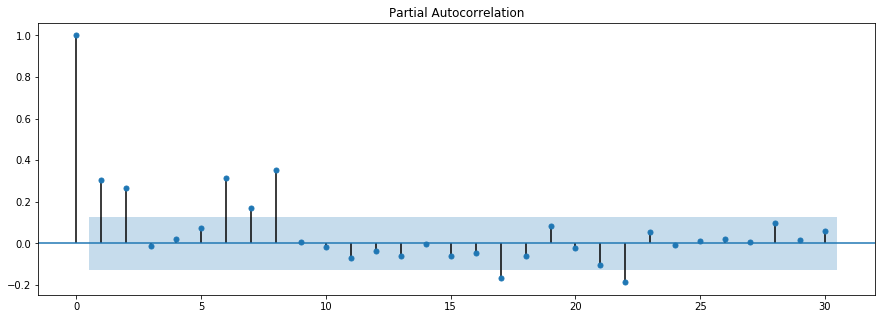

In [92]:
# plot partial autocorrelation for ARCH model
fig = plt.figure(figsize=(15,5))
ax1=fig.add_subplot(1,1,1)
fig = sm.graphics.tsa.plot_pacf(eps_t2,lags = 30,ax = ax1)

From the figure above, we can let $p = 8$ and choose ARCH(8) as volatility model. 

#### Step 4 - Integrate the above two models into an AR-ARCH model
Based on our previous analysis, we can roughly choose the mean model as the AR(2) model, and the volatility model as the ARCH(8) model.

$$\begin{align*}
\qquad & r_t = c_1 + \sum_{i=1}^2{\phi_i r_{t-i}} + \epsilon_t \\
\qquad & \epsilon_t = u_t \sigma_t  \qquad &u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = k + \sum_{i=1}^8{\alpha_i \sigma_{t-i}^2} \\
\end{align*}$$

We use the arch package in Python to implement the model.

In [69]:
# build AR-ARCH model
ar_arch = arch.arch_model(data.returns,mean='AR',lags=2,vol='ARCH',p=8)
# fit the SP500 returns data
res_ar_arch = ar_arch.fit()
# show results
res_ar_arch.summary()

Iteration:      1,   Func. Count:     14,   Neg. LLF: 433.10297417795107
Iteration:      2,   Func. Count:     31,   Neg. LLF: 430.4969379549317
Iteration:      3,   Func. Count:     46,   Neg. LLF: 428.840998117621
Iteration:      4,   Func. Count:     62,   Neg. LLF: 428.23753954912115
Iteration:      5,   Func. Count:     78,   Neg. LLF: 428.0651168297728
Iteration:      6,   Func. Count:     93,   Neg. LLF: 426.9816009772683
Iteration:      7,   Func. Count:    108,   Neg. LLF: 426.37354530603795
Iteration:      8,   Func. Count:    123,   Neg. LLF: 425.70377284392646
Iteration:      9,   Func. Count:    138,   Neg. LLF: 425.0289297395038
Iteration:     10,   Func. Count:    153,   Neg. LLF: 423.8221116644514
Iteration:     11,   Func. Count:    168,   Neg. LLF: 423.29691024123775
Iteration:     12,   Func. Count:    182,   Neg. LLF: 422.16679005067954
Iteration:     13,   Func. Count:    198,   Neg. LLF: 422.16483113309573
Iteration:     14,   Func. Count:    212,   Neg. LLF: 422.

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:                returns   R-squared:                       0.129
Mean Model:                        AR   Adj. R-squared:                  0.122
Vol Model:                       ARCH   Log-Likelihood:               -422.074
Distribution:                  Normal   AIC:                           868.148
Method:            Maximum Likelihood   BIC:                           909.663
                                        No. Observations:                  235
Date:                Fri, Feb 05 2021   Df Residuals:                      223
Time:                        20:20:39   Df Model:                           12
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const          0.1324  9.762e-02      1.357      0.175 [-5.890e-02,  0.324]
returns[1]    -0.0778  7.529e-02     -1.033      0.302  [ -0.225,6.981e-02]
returns[2]     0.1682      0.114      1.471      0.141 [-5.588e-02,  0.392]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.7844      0.323      2.430  1.509e-02 [  0.152,  1.417]
alpha[1]       0.1714      0.163      1.054      0.292 [ -0.147,  0.490]
alpha[2]       0.4520      0.381      1.188      0.235 [ -0.294,  1.198]
alpha[3]   1.8784e-12  5.130e-02  3.661e-11      1.000 [ -0.101,  0.101]
alpha[4]       0.0000      0.230      0.000      1.000 [ -0.450,  0.450]
alpha[5]       0.0000      0.415      0.000      1.000 [ -0.814,  0.814]
alpha[6]       0.1275      0.124      1.027      0.305 [ -0.116,  0.371]
alpha[7]       0.0000      0.102      0.000      1.000 [ -0.199,  0.199]
alpha[8]       0.0000      0.113      0.000      1.000 [ -0.221,  0.221]
========================================================================

Covariance estimator: robust
"""

We get our fitting model:

$$\begin{align*}
\qquad & r_t = 0.1324 - 0.0778 r_{t-1} + 0.1682 r_{t-2} + \epsilon_t \\
\qquad & \epsilon_t = u_t \sigma_t  \qquad & u_t \sim N(0,1) \\
\qquad & \sigma_t^2 = 0.7844 + 0.1714 \sigma_{t-1}^2 + 0.4520 \sigma_{t-2}^2 + 0.1275 \sigma_{t-6}^2 \\
\end{align*}$$

From the statistic, our model is not so suitable, since the R square and adjusted R square are both low, and AIC, BIC are both high. We then take a loot at the fitting result to find our problems.

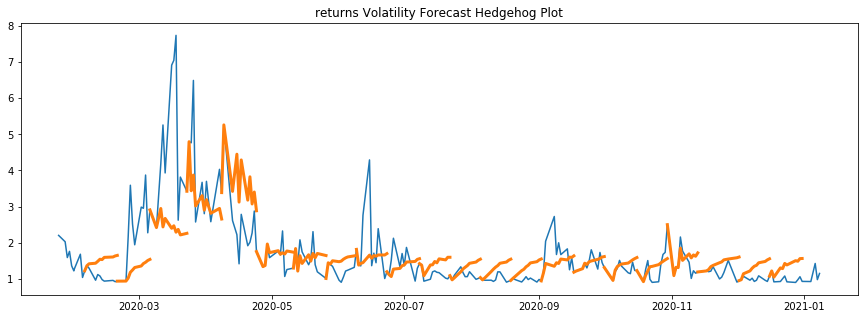

In [94]:
fig = res_ar_arch.hedgehog_plot(plot_type='volatility')
plt.rcParams['figure.figsize'] = (15, 5)
plt.show()

In the picture, the blue line is the original return rate volatility sequence, and the orange line is the predicted volatility sequence. It can be found that the spikes during 2020 March to 2020 May causes the model to overestimate the averge volatility. As a result, despite volatility went back to normal in the latter period, our model still predicts that the volatility would go up to a higher level. 

### Mini-conclusion

AR-ARCH model are commonly employed in modeling financial time series that exhibit time-varying volatility and volatility clustering. But in COVID era, it performs poorly due to extreme volatility caused by outer shocks. As a result, we must incorporate the compact of COVID into our model to better fitting the volatility spikes. 

##  Frequentist model II : Forecasting VIX using ARX model, COVID as an exogenous variable

We want to add COVID as an exogenous variable in the GARCH model. Unfortunately, Python has no packages that can solve GARCH-X model, so we simplify the situation and switch to ARX model that use COVID as an exogenous variable to fit US VIX index.

First we plot the graph for VIX index and log of the COVID cases growth in US.

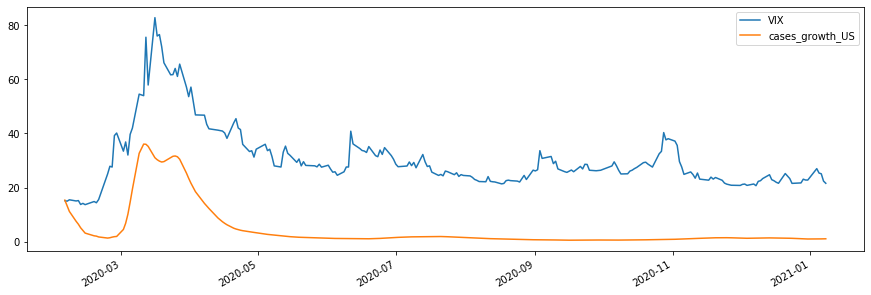

In [98]:
# get VIX data
sp500_vol = data.VIX
# drop the irrelavant data
sp500_vol = sp500_vol.iloc[11:].fillna(method='ffill')
# get COVID data
covid_us = data.cases_growth_US * 100
# rop the irrelavant data
covid_us = covid_us.iloc[11:]
# plot the figure
sp500_vol.plot(figsize=(15,5))
covid_us.plot()
plt.legend()
plt.show()

Then we use ARX to fit the data. That is:

$$\begin{align*}
\qquad & vol_t = c_1 + \phi_1 vol_{t-1} + \alpha_1 covid_t + \epsilon_t \qquad &\epsilon_t \sim N(0,\sigma^2)\\
\end{align*}$$<br>

In [90]:
from arch.univariate import ARX, Normal
# build ARX model
arx_model = ARX(y = sp500_vol, x = covid_us, lags=1, distribution=Normal())
# fit our data
res_arx = arx_model.fit()
# show results
res_arx.summary

<bound method ARCHModelResult.summary of                     AR-X - Constant Variance Model Results                    
Dep. Variable:                    VIX   R-squared:                       0.913
Mean Model:                      AR-X   Adj. R-squared:                  0.912
Vol Model:          Constant Variance   Log-Likelihood:               -599.398
Distribution:                  Normal   AIC:                           1206.80
Method:            Maximum Likelihood   BIC:                           1220.46
                                        No. Observations:                  225
Date:                Fri, Feb 05 2021   Df Residuals:                      221
Time:                        20:45:54   Df Model:                            4
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          5.1063  

Our fitting model is:

$$\begin{align*}
\qquad & vol_t = 5.1063 + 0.7952 vol_{t-1} + 0.2721 covid_t + \epsilon_t \qquad &\epsilon_t \sim N(0,12.0625)\\
\end{align*}$$

It is good news that all the p-values are less than the significant level and adjusted R square is large. However, we still see that AIC and BIC is high, which is not satisfying. Also, we need to check whether the model has the ARCH effect.

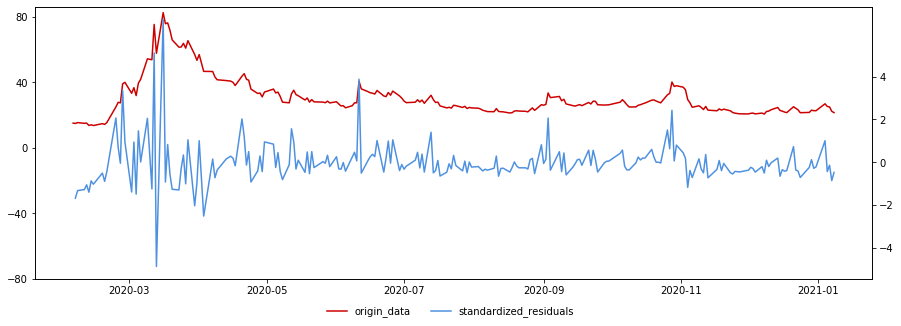

In [101]:
# plot the residuals and original data
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5),)
ax2 = ax1.twinx()
blue = tuple(np.array([78, 145, 224]) / 255)
red = tuple(np.array([205, 0, 0]) / 255)
ax1.plot(sp500_vol,label='origin_data',color=red)
ax2.plot(res_arx.std_resid,label='standardized_residuals',color=blue)
ax1.set_yticks(np.arange(-80,120,40))
ax2.set_yticks(np.arange(-4,6,2))
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
legend1 = fig.legend(handles1+handles2, labels1+labels2,loc='lower center',ncol=2,frameon=False)
plt.show()

By the results above, the model has the problem of conditional heteroskedasticity, so ARX with COVID is not enough to model the data.

### Mini-conclusion

while adding COVID data into our frequentist model significantly improves our result, it still has several issues. First, there is no ARCH-X or GARCH-X model that we can use in current Python environment, so the result above is just an approximation by VIX data, which does not accurately demonstrate the volatility of real SP500 volatility. Second, our ARX model has ARCH effect, which means ARX alone can not fully capture the patterns of VIX index.